In [1]:
import os, sys
LibPath = '../'
if LibPath in sys.path:
    print('YES')
else:
    print('NO, we\'ll add it now')
    sys.path.append(LibPath)
import warnings
warnings.filterwarnings("ignore")

NO, we'll add it now


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

from random import shuffle
from tqdm import tqdm
from scipy.cluster.hierarchy import linkage, fcluster, leaders, ClusterNode
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from Libraries.Util import Norm01, MovingAverage, RemTrend, F1metr
from Libraries.graph import AdjMatr, TransMatr, GraphEntropy
from Libraries.features import  CEmbDim #CCorrent, CHurst,

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [4]:
def make_traject(row):
    mindist=.03
    demb=8  #CEmbDim(row)# В локальной версии можно рассчитывать #from Libraries.features import CCorrent, CHurst, CEmbDim
    depth=demb#*2+1
    traject=pd.DataFrame(columns=['step']+['t-'+str(j) for j in range(depth-1,-1,-1)])
    traject['step']=np.arange(len(row)-depth)
    for i in range(len(row)-depth):
        traject.loc[i, traject.columns[1:]]=row[i:i+depth]
    '''матрица связей для кластеризации'''
    link = linkage(traject[traject.columns[1:]], 'ward', 'euclidean')
    '''оптимальное расстояние для кластеризации'''
    dist = link[:, 2]
    dist_rev = dist[::-1]
    i=np.where(np.abs(dist_rev[:-5]-dist_rev[5:])<(max(dist_rev)*mindist))[0][0]
    d=dist_rev[i]
    '''кластеризация'''
    traject['cluster']=fcluster(link, d, criterion='distance')
    traject['cluster']=[list(traject['cluster'].drop_duplicates().values).index(i)+1 for i in traject['cluster']]
    traject['cluster']=traject['cluster'].astype(int)
    '''делание графа''' 
    return traject
def make_gr(traject):
    nod=traject['cluster'].values
    G=nx.DiGraph()
    clu=traject['cluster'].unique() 
    nodes=[i for i in zip(clu, [{'points':len(traject[traject.cluster==c])/len(traject), #node capacity
                                 'mean':np.mean(traject[traject.cluster==c]['t-0'].values)} for c in clu])] #mean value of the data in the node
    #np.asarray(list(nx.degree_centrality(G).values()))
    G.add_nodes_from(nodes)
    r=[(nod[j], nod[j+1]) for j in range(len(traject)-1)]
    c=[r.count(i) for i in r]
    G.add_weighted_edges_from([(nod[j], nod[j+1],c[j]) for j in range(len(traject)-1)])
    return G
def show_gr(G):
    fig=plt.figure(figsize=(7, 7))
    lnd=G.number_of_nodes()+1
    nnd=lnd//7
    nlist=[range(i,i+lnd//nnd) for i in range(0,lnd-lnd//nnd,lnd//nnd)]+[range(lnd-lnd//nnd,lnd)]
    nx.draw(G, pos=nx.shell_layout(G, nlist=nlist),
                   with_labels=True,
                   node_color='pink', font_weight='bold',font_size=10,
                   edge_color='b',node_size=300, width=2 )
    #nx.spectral_layout(G), random, circular
    fig.tight_layout()
    plt.show()
    return 0

In [7]:
ds=pd.read_csv('artdata_1000.csv')
scores=pd.read_csv('art1000_RF_RMSE.csv')
# ds=pd.read_csv('real_data.csv')
# scores=pd.read_csv('real_XGB_RMSE.csv')

nlevel=5
'''Поровну на класс'''
labels=pd.DataFrame(columns=['series', 'level'])
allser=scores.columns[2:]#.tolist()
labels.series=allser
a={}
for i in range(nlevel):
    labels['score%i'%i]=scores.loc[i, allser].values
for i in range(nlevel):
    a[i]=labels[labels['score%i'%i].rank(method='dense') <= len(allser)//nlevel].series.values
    labels=labels.drop(labels[labels['score%i'%i].rank(method='dense') <= len(allser)//nlevel].index)

labels=pd.DataFrame(columns=['series', 'level'])
allser=scores.columns[2:]#.tolist()
labels.series=allser
for i in a.keys():
    labels.loc[labels.series.isin(a[i]), 'level']=i
#labels.level=np.where(labels.level.values <5, 0, 1) #for binary!
labels['l2']=labels.index.values.astype(int)//(len(allser)//nlevel)
for i in range(nlevel):
    labels['score%i'%i]=scores.loc[i, allser].values
labels
# '''+++++++++++++++++++++++++++++++++++++++++++++'''
minimals=labels.iloc[:,2:].min(axis=1).copy()
# b=np.quantile(minimals, [.2, .4, .6, .8, 1.])

# ''' решето - ставим метки'''
# allser=scores.columns[2:]#.tolist()
# for i in range(nlevel):
#     j=minimals[minimals.values<=b[i]].index
#     print('level %i - quantile %.3f: %i items'%(i, b[i], len(j)))
#     labels.iloc[labels.index[labels.series.isin(allser[j]).tolist()], 1]=i
#     minimals=minimals.drop(j)
# labels=labels.fillna(value=4)
# # allser=scores.columns[2:]
# # for i in range(nlevel):
# #     labels['score%i'%i]=scores.loc[i, allser].values
# labels

,series,level,l2,score0,score1,score2,score3,score4
0,000,0,0,0.001288,0.000890,0.000810,0.000649,0.000404
1,001,0,0,0.001715,0.000725,0.000761,0.000400,0.000444
2,002,0,0,0.000907,0.000967,0.000955,0.001555,0.000842
3,003,0,0,0.001471,0.001421,0.000815,0.000994,0.000605
4,004,0,0,0.001345,0.001146,0.001246,0.001220,0.000882
...,...,...,...,...,...,...,...,...
995,995,3,4,0.025836,0.022222,0.022334,0.018768,0.019848
996,996,3,4,0.035977,0.031894,0.034230,0.025603,0.026927
997,997,4,4,0.055089,0.043318,0.035213,0.035381,0.034008
998,998,4,4,0.053587,0.047700,0.042947,0.048238,0.048235


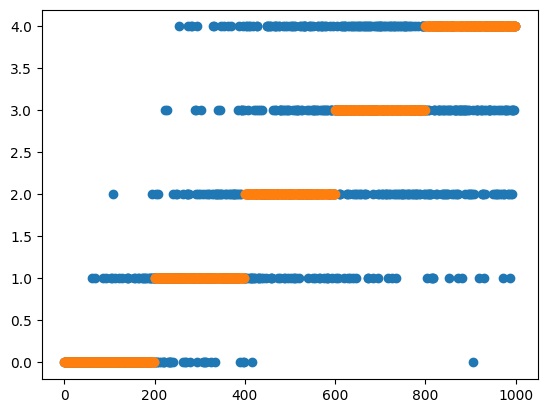

In [8]:
matplotlib.style.use('default')
plt.scatter(labels.index, labels.level)
plt.scatter(labels.index, labels.l2)
#plt.scatter(labels.index, labels.series.astype(int)//100)

In [266]:
'''делание графов'''
nG=[]
for c in tqdm(ds.columns[1:]):
    l=labels[labels.series==c].level.values[0]
    row=ds[c].values
    row=Norm01(row)[0]
    traject=make_traject(row)
    G=make_gr(traject)
    tG=from_networkx(G, group_node_attrs=['points','mean'], group_edge_attrs=all) 
    cent=np.asarray(list(nx.degree_centrality(G).values()))# degree_centrality to node features
    cent=torch.tensor(cent.reshape(len(cent),1), dtype=float)
    tG.x=torch.cat((tG.x, cent),1) #node centrality to feture list
    tG.x=tG.x.float()
    tG.y=torch.tensor([l])
    nG.append(tG)
print('Done!', len(nG))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:36<00:00,  1.75it/s]


Done! 1000


In [394]:
l=labels.iloc[:,2:].values.argmin(axis=1)
labels.level=l

In [556]:
'''смена меток'''
for i, tG in enumerate(nG):
    tG.y = torch.tensor([int(labels.level.values[i])])

In [557]:
tG.y

tensor([4])

In [558]:
batch=10
loader = DataLoader(nG.copy(), batch_size=batch, shuffle=True)
dataset=loader.dataset
print()
#print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
#print(f'Number of features: {dataset.num_features}')
#print(f'Number of classes: {dataset.num_classes}')

d = dataset[0]  # Get the first graph object.

print()
print(d)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {d.num_nodes}')
print(f'Number of edges: {d.num_edges}')
print(f'Average node degree: {d.num_edges / d.num_nodes:.2f}')
print(f'Has isolated nodes: {d.has_isolated_nodes()}')
print(f'Has self-loops: {d.has_self_loops()}')
print(f'Is undirected: {d.is_undirected()}')


Number of graphs: 1000

Data(edge_index=[2, 26], x=[13, 3], edge_attr=[26, 1], y=[1])
Number of nodes: 13
Number of edges: 26
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


In [559]:
shuffle(dataset)
ttprop=int(len(labels)/3*2)
train_dataset = dataset[:ttprop]
test_dataset = dataset[ttprop:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = DataLoader(train_dataset, batch_size=35, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=35, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Number of training graphs: 666
Number of test graphs: 334
Step 1:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 924], x=[369, 3], edge_attr=[924, 1], y=[35], batch=[369], ptr=[36])

Step 2:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 941], x=[363, 3], edge_attr=[941, 1], y=[35], batch=[363], ptr=[36])

Step 3:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 913], x=[357, 3], edge_attr=[913, 1], y=[35], batch=[357], ptr=[36])

Step 4:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 949], x=[373, 3], edge_attr=[949, 1], y=[35], batch=[373], ptr=[36])

Step 5:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 926], x=[383, 3], edge_attr=[926, 1], y=[35], batch=[383], ptr=[36])

Step 6:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 940], x=[368, 3], edge_attr=[940, 1], y=[35], batch=[368], ptr=[36])

Step 7:
Number of graphs in the current batch: 35
DataBatch(edge_index=[

In [560]:
del model
torch.cuda.empty_cache()

In [561]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(3, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, nlevel)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64)#.to(device)
#data = dataset[0].to(device)
print(model)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
)


In [562]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
def train(train_loader):
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

def predict(data):
    model.eval()
    out = model(data.x, data.edge_index, torch.tensor([0]))  
    pred = out.argmax(dim=1)[0:1]
    return pred

acc=[]
for epoch in range(101):
    train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    acc.append((train_acc, test_acc))
    if epoch%10==0:
        print(f'Epoch: {epoch:3d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:   0, Train Acc: 0.4384, Test Acc: 0.4581
Epoch:  10, Train Acc: 0.4850, Test Acc: 0.4850
Epoch:  20, Train Acc: 0.5345, Test Acc: 0.5269
Epoch:  30, Train Acc: 0.5706, Test Acc: 0.5689
Epoch:  40, Train Acc: 0.4925, Test Acc: 0.4731
Epoch:  50, Train Acc: 0.5751, Test Acc: 0.5749
Epoch:  60, Train Acc: 0.6171, Test Acc: 0.6228
Epoch:  70, Train Acc: 0.6201, Test Acc: 0.6317
Epoch:  80, Train Acc: 0.5976, Test Acc: 0.6168
Epoch:  90, Train Acc: 0.6486, Test Acc: 0.6347
Epoch: 100, Train Acc: 0.6291, Test Acc: 0.6168


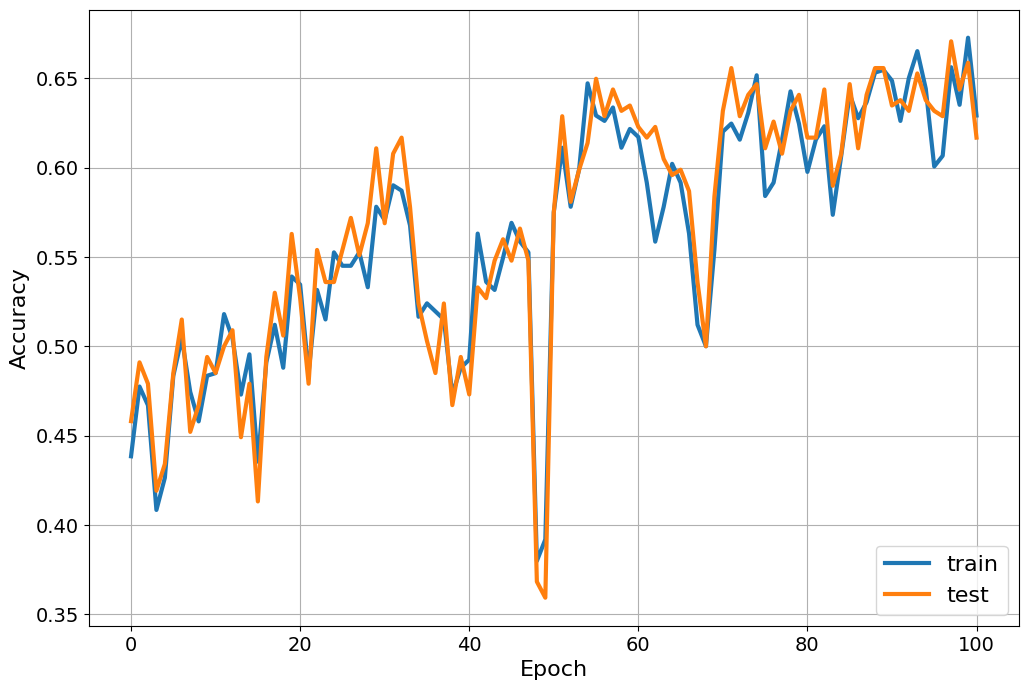

In [563]:
matplotlib.style.use('default')
plt.figure(figsize=(12,8), facecolor='w') 
plt.plot(acc, label=['train','test'], lw=3)
plt.legend(loc=4, fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Epoch', size=16)
plt.ylabel('Accuracy', size=16)
plt.grid()
plt.show()

In [564]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred=[]
y_true=[]
for data in test_dataset:
    y_pred.append(predict(data).numpy()[0])
    y_true.append(data.y.numpy()[0])
confusion_matrix(y_true, y_pred), confusion_matrix(y_true, y_pred).sum()

(array([[63,  8,  0,  0,  0],
        [11, 28, 23,  6,  0],
        [ 0,  7, 33, 23,  0],
        [ 0,  1,  9, 45, 13],
        [ 0,  0,  2, 27, 35]], dtype=int64), 334)

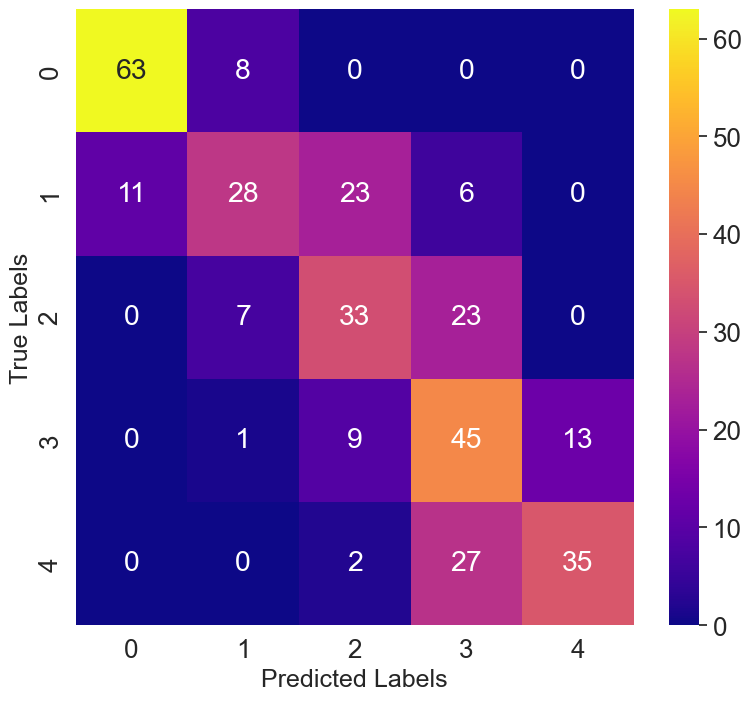

In [565]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(font_scale=1.7)
plt.figure(figsize = (9,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, 
            xticklabels = np.unique(y_true), yticklabels = np.unique(y_true), cmap = 'plasma')
plt.xlabel('Predicted Labels', size=18)
plt.ylabel('True Labels', size=18)
plt.show()
#plt.savefig('newpic/classifier_test.png', dpi=300, format='png' )

In [566]:
'''Метрики для всех классов'''
x=np.array(y_true)
y=np.array(y_pred)
cm=confusion_matrix(y_true, y_pred)
print('F1=%.2f, Acc.=%.0f%%'%F1metr(y,x))
'''и по отдельности'''
ff=[]
ac=[]
for i in range(nlevel):
    a=np.where(x==i, 1, 0)
    b=np.where(y==i, 1, 0)
    print('Label:%i'%i ,'F1=%.2f, Acc.=%.0f%%'%(F1metr(b,a)[0], cm[i,i]/sum(cm[:,i])*100))
    ff.append(F1metr(b,a)[0])
    ac.append(cm[i,i]/sum(cm[:,i])*100)

F1=0.75, Acc.=83%
Label:0 F1=0.87, Acc.=85%
Label:1 F1=0.50, Acc.=64%
Label:2 F1=0.51, Acc.=49%
Label:3 F1=0.53, Acc.=45%
Label:4 F1=0.62, Acc.=73%


In [567]:
sum(ff)/5, sum(ac)/5

(0.6068404407263823, 63.099270445398716)

In [594]:
fdata='real_data.csv'#'artdata_1000.csv'
fname='real_XGB_RMSE.csv'#'art1000_XGB_acc_time.csv'#'real_XGB_acc_time.csv'
df=pd.read_csv(fdata)#'artdata_350.csv'
scores=pd.read_csv(fname)[:10]

nlevel=5
'''Поровну на класс'''
labels=pd.DataFrame(columns=['series', 'level'])
allser=scores.columns[2:]#.tolist()
labels.series=allser
a={}
for i in range(nlevel):
    labels['score%i'%i]=scores.loc[i, allser].values
for i in range(nlevel):
    a[i]=labels[labels['score%i'%i].rank(method='dense') <= len(allser)//nlevel].series.values
    labels=labels.drop(labels[labels['score%i'%i].rank(method='dense') <= len(allser)//nlevel].index)

labels=pd.DataFrame(columns=['series', 'level'])
allser=scores.columns[2:]#.tolist()
labels.series=allser
for i in a.keys():
    labels.loc[labels.series.isin(a[i]), 'level']=4-i
for i in range(nlevel):
    labels['score%i'%i]=scores.loc[i, allser].values
labels

minimals=labels.iloc[:,2:].min(axis=1).copy()
b=np.quantile(minimals, [.2, .4, .6, .8, 1.])

''' решето - ставим метки'''
allser=scores.columns[2:]#.tolist()
for i in range(nlevel):
    j=minimals[minimals.values<=b[i]].index
    print('level %i - quantile %.3f: %i items'%(i, b[i], len(j)))
    labels.iloc[labels.index[labels.series.isin(allser[j]).tolist()], 1]=4-i
    minimals=minimals.drop(j)
labels=labels.fillna(value=4)
labels

level 0 - quantile 0.013: 36 items
level 1 - quantile 0.020: 36 items
level 2 - quantile 0.040: 36 items
level 3 - quantile 0.063: 36 items
level 4 - quantile 0.100: 36 items


,series,level,score0,score1,score2,score3,score4
0,con00,1,0.063464,0.061800,0.061691,0.061505,0.061938
1,con01,0,0.072214,0.071978,0.071737,0.071994,0.071694
2,con02,0,0.081829,0.081513,0.080751,0.080700,0.080266
3,con03,0,0.079168,0.079550,0.079643,0.079601,0.079825
4,con04,0,0.066330,0.067079,0.067235,0.067493,0.067212
...,...,...,...,...,...,...,...
175,stc85,3,0.019106,0.018261,0.018705,0.018446,0.018768
176,stc86,3,0.020215,0.020184,0.020049,0.020043,0.020013
177,stc87,4,0.009742,0.010146,0.010424,0.009101,0.010031
178,stc88,1,0.045989,0.045755,0.045783,0.045898,0.045822


In [595]:
'''смена меток'''
for i, tG in enumerate(nGr):
    tG.y = torch.tensor([int(labels.level.values[i])])
    #tG.y = torch.tensor([y_pred[i]])

In [579]:
'''делание графов из реальных рядов'''
nGr=[]
for c in tqdm(df.columns[1:]):
    l=labels[labels.series==c].level.values[0]
    row=df[c].values[250:]
    #row=RemTrend(row)[0]
    #row=MovingAverage(row, numb=15)
    row=Norm01(row)[0]
    traject=make_traject(row)
    G=make_gr(traject)
    tG=from_networkx(G, group_node_attrs=['points','mean'], group_edge_attrs=all) 
    cent=np.asarray(list(nx.degree_centrality(G).values()))# degree_centrality to node features
    cent=torch.tensor(cent.reshape(len(cent),1), dtype=float)
    tG.x=torch.cat((tG.x, cent),1) #node centrality to feture list
    tG.x=tG.x.float()
    tG.y=torch.tensor([l])
    nGr.append(tG)
print('Done!', len(nGr))

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:51<00:00,  3.42it/s]


Done! 180


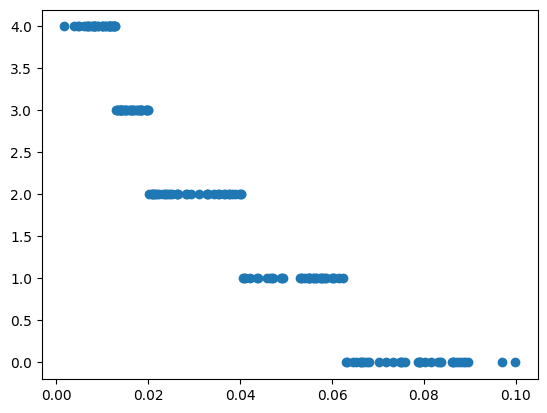

In [596]:
matplotlib.style.use('default')
minimals=labels.iloc[:,2:].min(axis=1).copy()
plt.scatter(minimals, labels.level)

In [597]:
batch=10
loader = DataLoader(nGr.copy(), batch_size=batch, shuffle=True)
dataset=loader.dataset
print()
#print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
#print(f'Number of features: {dataset.num_features}')
#print(f'Number of classes: {dataset.num_classes}')

d = dataset[0]  # Get the first graph object.

print()
print(d)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {d.num_nodes}')
print(f'Number of edges: {d.num_edges}')
print(f'Average node degree: {d.num_edges / d.num_nodes:.2f}')
print(f'Has isolated nodes: {d.has_isolated_nodes()}')
print(f'Has self-loops: {d.has_self_loops()}')
print(f'Is undirected: {d.is_undirected()}')


y_pred=[]
y_true=[]
for data in dataset:
    y_pred.append(predict(data).numpy()[0])
    y_true.append(data.y.numpy()[0])
confusion_matrix(y_true, y_pred)


Number of graphs: 180

Data(edge_index=[2, 28], x=[13, 3], edge_attr=[28, 1], y=[1])
Number of nodes: 13
Number of edges: 28
Average node degree: 2.15
Has isolated nodes: False
Has self-loops: True
Is undirected: False


array([[ 7,  2, 19,  2,  6],
       [ 5,  2, 14,  5, 10],
       [ 1,  1, 11,  9, 14],
       [ 2,  0,  2, 10, 22],
       [ 1,  2,  1,  6, 26]], dtype=int64)

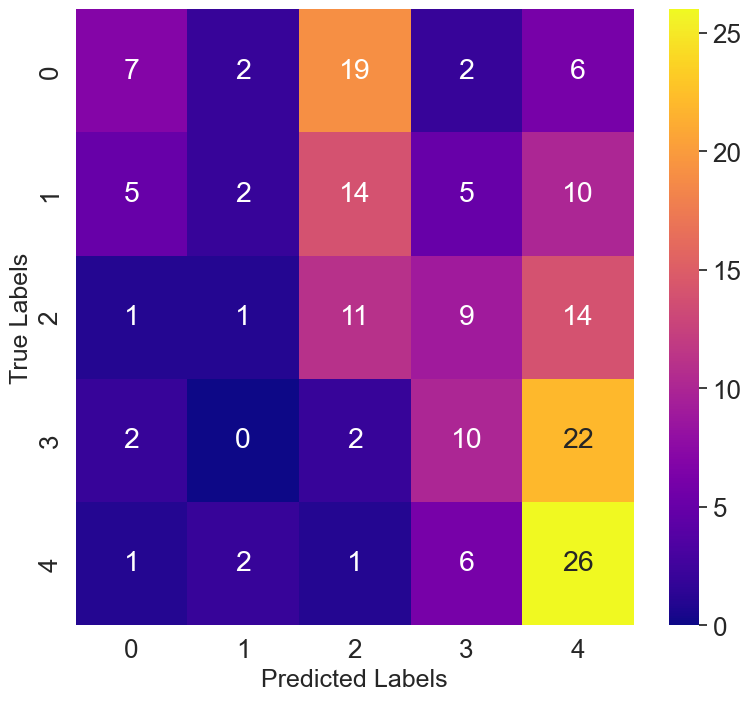

In [598]:
plt.figure(figsize = (9,8))
sns.set(font_scale=1.7)
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, xticklabels = np.unique(y_true), yticklabels = np.unique(y_true), cmap = 'plasma')
plt.xlabel('Predicted Labels',size=18)
plt.ylabel('True Labels',size=18)
plt.show()
#plt.savefig('newpic/classifier_real.png', dpi=300, format='png' )

In [600]:
'''Метрики для всех классов'''
x=np.array(y_true)
y=np.array(y_pred)
cm=confusion_matrix(y_true, y_pred)
print('F1=%.2f, Acc.=%.0f%%'%F1metr(y,x))
'''и по отдельности'''
ff=[]
ac=[]
for i in range(nlevel):
    a=np.where(x==i, 1, 0)
    b=np.where(y==i, 1, 0)
    print('Label:%i'%i ,'F1=%.2f, Acc.=%.0f%%'%(F1metr(b,a)[0], cm[i,i]/36*100))
    ff.append(F1metr(b,a)[0])
    ac.append(cm[i,i]/sum(cm[i,:])*100)

F1=0.36, Acc.=56%
Label:0 F1=0.27, Acc.=19%
Label:1 F1=0.09, Acc.=6%
Label:2 F1=0.27, Acc.=31%
Label:3 F1=0.29, Acc.=28%
Label:4 F1=0.46, Acc.=72%


In [601]:
np.mean(ff), np.mean(ac), ac

(0.27551445278891895,
 31.111111111111107,
 [19.444444444444446,
  5.555555555555555,
  30.555555555555557,
  27.77777777777778,
  72.22222222222221])

In [402]:
cm=confusion_matrix(y_true, y_pred)
sum([cm[i,i] for i in range(nlevel)])/cm.sum(), sum(np.array(ff))
for i in range(nlevel):
    print(cm[i,i]/sum(cm[:,i]))

0.4444444444444444
0.3902439024390244
0.21428571428571427
0.32142857142857145
0.4117647058823529


In [386]:
np.where(a==b)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  27,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  92,  93,  95,  97,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 113, 114, 116,
        117, 122, 123, 124, 125, 128, 129, 132, 133, 134, 135, 136, 137,
        138, 139, 142, 144, 151, 153, 154, 156, 157, 160, 162, 168, 169,
        170, 174, 176, 178, 179], dtype=int64),)